In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
from matplotlib.ticker import FuncFormatter
from pandas.api.types import CategoricalDtype
%matplotlib inline


In [27]:
pd.set_option('display.max_rows', 10)

In [3]:
# Source: http://web.mta.info/developers/turnstile.html
def get_data(week_nums):
    url = "http://web.mta.info/developers/data/nyct/turnstile/turnstile_{}.txt"
    dfs = []
    for week_num in week_nums:
        file_url = url.format(week_num)
        dfs.append(pd.read_csv(file_url))
    return pd.concat(dfs)

In [4]:
week_nums = [190608, 190615, 190622, 190629]
df = get_data(week_nums)

In [5]:
df.reset_index(inplace = True)
df.drop(columns='index', inplace=True)
# df.info()

In [6]:
# Check for duplicates, and none of them are duplicates
# If there is, drop them by using: df = df.drop_duplicates()
df.drop_duplicates(inplace=True)
df.duplicated().value_counts() 

False    823385
dtype: int64

In [7]:
# Convert Date and Time to Datetime objects
df['DATETIME']= pd.to_datetime(df['DATE'] +' '+ df['TIME'])
df['DATE'] = pd.to_datetime(df['DATE'])

In [8]:
weekdays = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]

df['DAY_OF_WEEK_NUM'] = df["DATE"].apply(lambda x: x.weekday())
df['DAY_OF_WEEK'] = df["DAY_OF_WEEK_NUM"].apply(lambda x: weekdays[x]).astype(
    CategoricalDtype(weekdays, ordered=True))
df['DAY_OF_WEEK_SUMMARY'] = df["DAY_OF_WEEK_NUM"].apply(lambda x: "Weekend" if int(x) >= 5 else "Weekday")

# Dropping previous column since it's not needed now
# df.drop(columns=["WEEKDAY_NUM"], inplace = True)
# df['DAY_OF_WEEK'] = [date.weekday() for date in df["DATE"].tolist()]

In [9]:
df.head(10)

,C/A,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,DESC,ENTRIES,EXITS,DATETIME,DAY_OF_WEEK_NUM,DAY_OF_WEEK,DAY_OF_WEEK_SUMMARY
0,A002,R051,02-00-00,59 ST,NQR456W,BMT,2019-06-01,00:00:00,REGULAR,7080105,2398899,2019-06-01 00:00:00,5,Saturday,Weekend
1,A002,R051,02-00-00,59 ST,NQR456W,BMT,2019-06-01,04:00:00,REGULAR,7080137,2398904,2019-06-01 04:00:00,5,Saturday,Weekend
2,A002,R051,02-00-00,59 ST,NQR456W,BMT,2019-06-01,08:00:00,REGULAR,7080161,2398937,2019-06-01 08:00:00,5,Saturday,Weekend
3,A002,R051,02-00-00,59 ST,NQR456W,BMT,2019-06-01,12:00:00,REGULAR,7080276,2399025,2019-06-01 12:00:00,5,Saturday,Weekend
4,A002,R051,02-00-00,59 ST,NQR456W,BMT,2019-06-01,16:00:00,REGULAR,7080520,2399084,2019-06-01 16:00:00,5,Saturday,Weekend
5,A002,R051,02-00-00,59 ST,NQR456W,BMT,2019-06-01,20:00:00,REGULAR,7080817,2399121,2019-06-01 20:00:00,5,Saturday,Weekend
6,A002,R051,02-00-00,59 ST,NQR456W,BMT,2019-06-02,00:00:00,REGULAR,7081001,2399154,2019-06-02 00:00:00,6,Sunday,Weekend
7,A002,R051,02-00-00,59 ST,NQR456W,BMT,2019-06-02,04:00:00,REGULAR,7081021,2399160,2019-06-02 04:00:00,6,Sunday,Weekend
8,A002,R051,02-00-00,59 ST,NQR456W,BMT,2019-06-02,08:00:00,REGULAR,7081035,2399179,2019-06-02 08:00:00,6,Sunday,Weekend
9,A002,R051,02-00-00,59 ST,NQR456W,BMT,2019-06-02,12:00:00,REGULAR,7081119,2399230,2019-06-02 12:00:00,6,Sunday,Weekend


In [10]:
# Create unique identifier for station and line 
# because some stations have the same name serving different line
df["STATION_ID"] = df["STATION"] + "_" + df["LINENAME"]

In [11]:
# Add bins to organize entries by 4-hour interval
bins = [-np.inf] + list(range(4, 25))[::4] ## Adding -np.inf to include 0AM (12AM)
time_of_day = ['12AM-4AM', '4AM-8PM', '8PM-12PM', '12PM-4PM', '4PM-8PM', '8PM-12AM']

df['HOUR_OF_DAY'] = [r.hour for r in df['DATETIME']] 
df['TIME_INTERVAL'] = pd.cut(df['HOUR_OF_DAY'], bins, labels = time_of_day)
df['TIME_INTERVAL'].astype(CategoricalDtype(time_of_day, ordered=True))

0         12AM-4AM
1         12AM-4AM
2          4AM-8PM
3         8PM-12PM
4         12PM-4PM
            ...   
823380     4AM-8PM
823381    8PM-12PM
823382    12PM-4PM
823383     4PM-8PM
823384    8PM-12AM
Name: TIME_INTERVAL, Length: 823385, dtype: category
Categories (6, object): [12AM-4AM < 4AM-8PM < 8PM-12PM < 12PM-4PM < 4PM-8PM < 8PM-12AM]

In [12]:
df['ENTRIES_DIFF'] = df.groupby(['STATION_ID','UNIT','SCP'], as_index=False)['ENTRIES'].transform(pd.Series.diff)['ENTRIES']

In [13]:
# Replace NaN/empties in 'ENTRIES_DIFF' with 0
df.fillna({'ENTRIES_DIFF': 0}, inplace=True)

# Convert 'ENTRIES_DIFF' to interger type
df.astype({'ENTRIES_DIFF': 'int64'}, copy=False)

# Convert negative entries to positive values (from turnstiles counting down instead of up)
df['ENTRIES_DIFF'] = abs(df['ENTRIES_DIFF'])

In [14]:
df.head(10)

,C/A,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,DESC,ENTRIES,EXITS,DATETIME,DAY_OF_WEEK_NUM,DAY_OF_WEEK,DAY_OF_WEEK_SUMMARY,STATION_ID,HOUR_OF_DAY,TIME_INTERVAL,ENTRIES_DIFF
0,A002,R051,02-00-00,59 ST,NQR456W,BMT,2019-06-01,00:00:00,REGULAR,7080105,2398899,2019-06-01 00:00:00,5,Saturday,Weekend,59 ST_NQR456W,0,12AM-4AM,0.0
1,A002,R051,02-00-00,59 ST,NQR456W,BMT,2019-06-01,04:00:00,REGULAR,7080137,2398904,2019-06-01 04:00:00,5,Saturday,Weekend,59 ST_NQR456W,4,12AM-4AM,32.0
2,A002,R051,02-00-00,59 ST,NQR456W,BMT,2019-06-01,08:00:00,REGULAR,7080161,2398937,2019-06-01 08:00:00,5,Saturday,Weekend,59 ST_NQR456W,8,4AM-8PM,24.0
3,A002,R051,02-00-00,59 ST,NQR456W,BMT,2019-06-01,12:00:00,REGULAR,7080276,2399025,2019-06-01 12:00:00,5,Saturday,Weekend,59 ST_NQR456W,12,8PM-12PM,115.0
4,A002,R051,02-00-00,59 ST,NQR456W,BMT,2019-06-01,16:00:00,REGULAR,7080520,2399084,2019-06-01 16:00:00,5,Saturday,Weekend,59 ST_NQR456W,16,12PM-4PM,244.0
5,A002,R051,02-00-00,59 ST,NQR456W,BMT,2019-06-01,20:00:00,REGULAR,7080817,2399121,2019-06-01 20:00:00,5,Saturday,Weekend,59 ST_NQR456W,20,4PM-8PM,297.0
6,A002,R051,02-00-00,59 ST,NQR456W,BMT,2019-06-02,00:00:00,REGULAR,7081001,2399154,2019-06-02 00:00:00,6,Sunday,Weekend,59 ST_NQR456W,0,12AM-4AM,184.0
7,A002,R051,02-00-00,59 ST,NQR456W,BMT,2019-06-02,04:00:00,REGULAR,7081021,2399160,2019-06-02 04:00:00,6,Sunday,Weekend,59 ST_NQR456W,4,12AM-4AM,20.0
8,A002,R051,02-00-00,59 ST,NQR456W,BMT,2019-06-02,08:00:00,REGULAR,7081035,2399179,2019-06-02 08:00:00,6,Sunday,Weekend,59 ST_NQR456W,8,4AM-8PM,14.0
9,A002,R051,02-00-00,59 ST,NQR456W,BMT,2019-06-02,12:00:00,REGULAR,7081119,2399230,2019-06-02 12:00:00,6,Sunday,Weekend,59 ST_NQR456W,12,8PM-12PM,84.0


In [15]:
# Remove outliers
df = df[df.groupby(['STATION_ID','SCP'])['ENTRIES_DIFF'].apply(lambda x: (np.abs(x - x.mean())/ x.std()) < 3)]

In [16]:
## [DATA] 

df_total_entries = df.groupby(['STATION_ID']).agg({'ENTRIES_DIFF': 'sum'}).sort_values(['ENTRIES_DIFF'], ascending=False).reset_index()
df_total_entries[:7]

,STATION_ID,ENTRIES_DIFF
0,GRD CNTRL-42 ST_4567S,3334584.0
1,34 ST-HERALD SQ_BDFMNQRW,2992110.0
2,42 ST-PORT AUTH_ACENQRS1237W,2208218.0
3,34 ST-PENN STA_ACE,2065539.0
4,14 ST-UNION SQ_LNQR456W,1698041.0
5,TIMES SQ-42 ST_1237ACENQRSW,1669489.0
6,FULTON ST_2345ACJZ,1453606.0


''

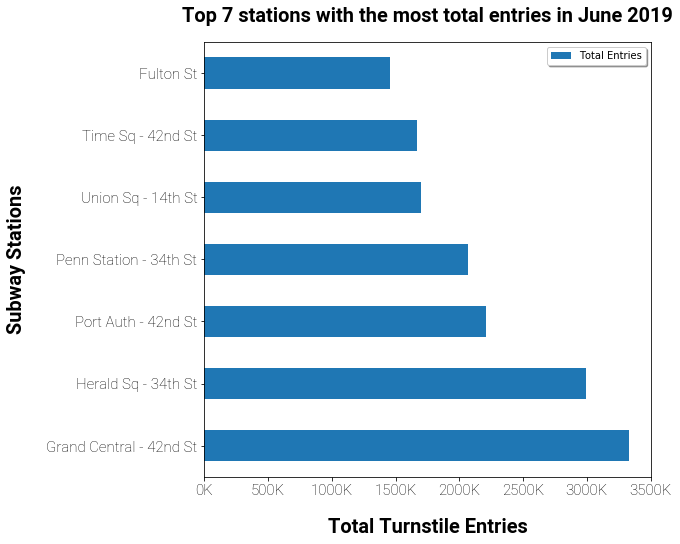

In [17]:
## [CHART] Top 7 stations with the most total entries in June 2019
chart_total_entries = df_total_entries[:7].plot(kind='barh', figsize=[8,8])
chart_total_entries.set_title("Top 7 stations with the most total entries in June 2019",
                             fontname="Roboto",
                             fontsize=20,
                             fontweight='bold',
                             pad=20)

xlabels = [str(int(x))+'K' for x in chart_total_entries.get_xticks()/1000]

chart_total_entries.set_xticklabels(xlabels)

chart_total_entries.set_xlabel("Total Turnstile Entries", 
                               fontname='Roboto', 
                               fontsize=20, 
                               fontweight='bold',
                               labelpad=20)

chart_total_entries.set_ylabel("Subway Stations", 
                               fontname='Roboto', 
                               fontsize=20, 
                               fontweight='bold', 
                               labelpad=20)

chart_total_entries.set_yticklabels(['Grand Central - 42nd St', 
                                    'Herald Sq - 34th St', 
                                    'Port Auth - 42nd St', 
                                    'Penn Station - 34th St', 
                                    'Union Sq - 14th St', 
                                    'Time Sq - 42nd St', 
                                    'Fulton St', 
                                    'Flushing Main'])

for tick in chart_total_entries.get_xticklabels():
    tick.set_fontname("Roboto")
    tick.set_fontsize(15)

for tick in chart_total_entries.get_yticklabels():
    tick.set_fontname("Roboto")
    tick.set_fontsize(15)
    
plt.legend(['Total Entries'], shadow=True)
;

In [18]:
## Top 7 stations with the most total entries during Weekdays in June 2019
mask_weekday = (df['DAY_OF_WEEK_SUMMARY'] == 'Weekday')
df_weekday_total_entries = df[mask_weekday].groupby(['STATION_ID']).agg({'ENTRIES_DIFF': 'sum'}).sort_values(['ENTRIES_DIFF'], ascending=False)
df_weekday_total_entries.reset_index(inplace=True)
df_weekday_total_entries

,STATION_ID,ENTRIES_DIFF
0,GRD CNTRL-42 ST_4567S,2900486.0
1,34 ST-HERALD SQ_BDFMNQRW,2427038.0
2,42 ST-PORT AUTH_ACENQRS1237W,1793158.0
3,34 ST-PENN STA_ACE,1725155.0
4,14 ST-UNION SQ_LNQR456W,1387636.0
...,...,...
473,BEACH 44 ST_A,14963.0
474,BEACH 98 ST_AS,11074.0
475,BROAD CHANNEL_AS,6395.0
476,BEACH 105 ST_AS,5746.0


''

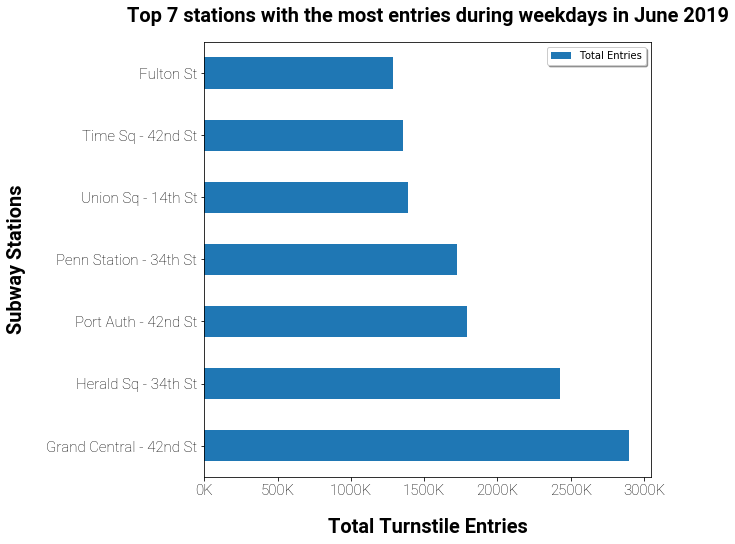

In [19]:
## [CHART] Top 7 stations with the most entries during Weekdays in June 2019
chart_weekday_total_entries = df_weekday_total_entries[:7].plot(kind='barh', figsize=[8,8])
chart_weekday_total_entries.set_title("Top 7 stations with the most entries during weekdays in June 2019",
                             fontname="Roboto",
                             fontsize=20,
                             fontweight='bold',
                             pad=20)

xlabels = [str(int(x))+'K' for x in chart_weekday_total_entries.get_xticks()/1000]

chart_weekday_total_entries.set_xticklabels(xlabels)

chart_weekday_total_entries.set_xlabel("Total Turnstile Entries", 
                               fontname='Roboto', 
                               fontsize=20, 
                               fontweight='bold',
                               labelpad=20)

chart_weekday_total_entries.set_ylabel("Subway Stations", 
                               fontname='Roboto', 
                               fontsize=20, 
                               fontweight='bold', 
                               labelpad=20)

chart_weekday_total_entries.set_yticklabels(['Grand Central - 42nd St', 
                                    'Herald Sq - 34th St', 
                                    'Port Auth - 42nd St', 
                                    'Penn Station - 34th St', 
                                    'Union Sq - 14th St', 
                                    'Time Sq - 42nd St', 
                                    'Fulton St', 
                                    'Path New'])

for tick in chart_weekday_total_entries.get_xticklabels():
    tick.set_fontname("Roboto")
    tick.set_fontsize(15)

for tick in chart_weekday_total_entries.get_yticklabels():
    tick.set_fontname("Roboto")
    tick.set_fontsize(15)
    
plt.legend(['Total Entries'], shadow=True)
;

In [29]:
top7 = list(df_total_entries['STATION_ID'][:7])
df_weekday_entries = df.groupby(['STATION_ID', 'DAY_OF_WEEK']).agg({'ENTRIES_DIFF': 'sum'}).reset_index()
df_weekday_entries = df_weekday_entries[df_weekday_entries['STATION_ID'].isin(top7)].sort_values("DAY_OF_WEEK", ascending=True).sort_index(level="STATION_ID", sort_remaining=False)
df_weekday_entries.reset_index(inplace=True)
df_weekday_entries.drop(columns='index', inplace=True)
df_weekday_entries


,STATION_ID,DAY_OF_WEEK,ENTRIES_DIFF
0,14 ST-UNION SQ_LNQR456W,Monday,258532.0
1,14 ST-UNION SQ_LNQR456W,Tuesday,271069.0
2,14 ST-UNION SQ_LNQR456W,Wednesday,289819.0
3,14 ST-UNION SQ_LNQR456W,Thursday,285490.0
4,14 ST-UNION SQ_LNQR456W,Friday,282726.0
...,...,...,...
44,TIMES SQ-42 ST_1237ACENQRSW,Wednesday,289048.0
45,TIMES SQ-42 ST_1237ACENQRSW,Thursday,280926.0
46,TIMES SQ-42 ST_1237ACENQRSW,Friday,277520.0
47,TIMES SQ-42 ST_1237ACENQRSW,Saturday,163612.0


''

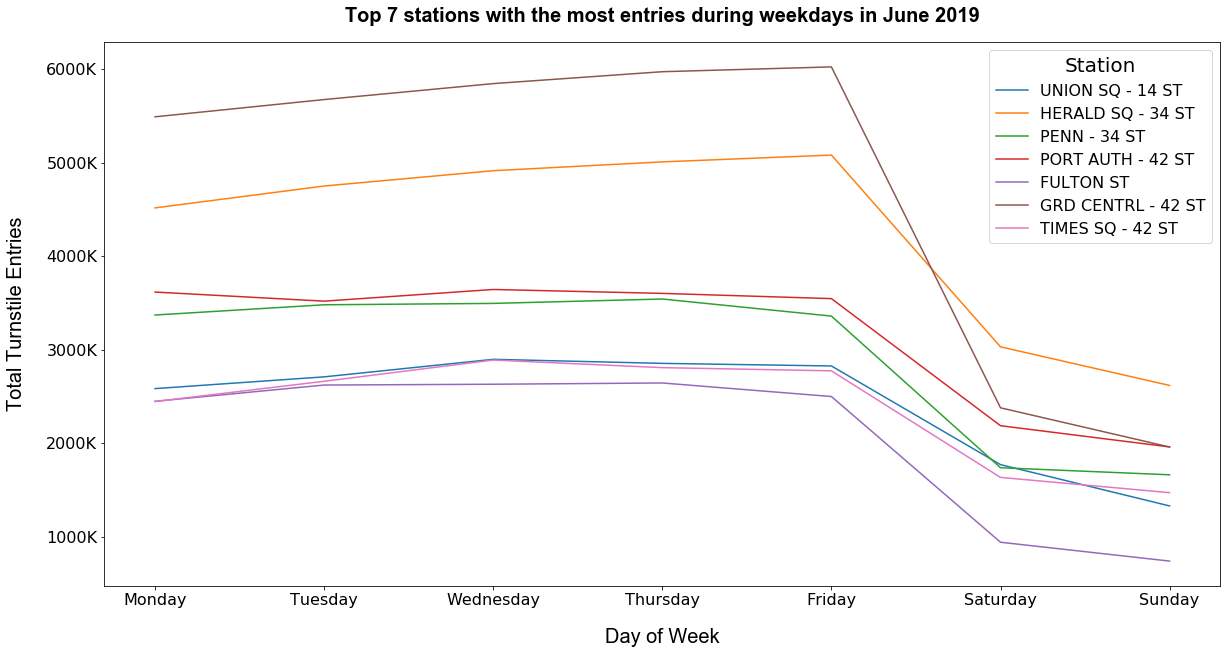

In [21]:
fig, axs = plt.subplots(figsize=[20, 10])

chart_weekday_entries = sns.lineplot(x = "DAY_OF_WEEK",
                                     y = "ENTRIES_DIFF",
                                     hue = "STATION_ID",
                                     data = df_weekday_entries)

chart_weekday_entries.set_title("Top 7 stations with the most entries during weekdays in June 2019",
                             fontname="Arial",
                             fontsize=20,
                             fontweight='bold',
                             pad=20)

ylabels = [str(int(y)) + "K" for y in chart_weekday_entries.get_yticks()/100]
chart_weekday_entries.set_yticklabels(ylabels)

chart_weekday_entries.set_ylabel("Total Turnstile Entries", 
                                 fontname='Arial', 
                                 fontsize=20, 
                                 labelpad=20)

chart_weekday_entries.set_xlabel("Day of Week", 
                                 fontname='Arial', 
                                 fontsize=20,
                                 labelpad=20)

chart_weekday_entries.tick_params(labelsize=16)


legend = ['UNION SQ - 14 ST','HERALD SQ - 34 ST','PENN - 34 ST','PORT AUTH - 42 ST','FULTON ST','GRD CENTRL - 42 ST','TIMES SQ - 42 ST']
chart_weekday_entries.legend(legend, title = "Station", fontsize=16, title_fontsize=20)




;

In [28]:
mask_top7 = df["STATION_ID"].isin(top7)
df_time_entries = df[mask_top7].groupby(["DAY_OF_WEEK", "TIME_INTERVAL"]).agg({'ENTRIES_DIFF': 'sum'}).reset_index()
df_time_entries


,DAY_OF_WEEK,TIME_INTERVAL,ENTRIES_DIFF
0,Monday,12AM-4AM,229199.0
1,Monday,4AM-8PM,204257.0
2,Monday,8PM-12PM,506241.0
3,Monday,12PM-4PM,411090.0
4,Monday,4PM-8PM,806882.0
...,...,...,...
37,Sunday,4AM-8PM,35174.0
38,Sunday,8PM-12PM,136841.0
39,Sunday,12PM-4PM,258633.0
40,Sunday,4PM-8PM,350352.0


In [30]:
pv_time_entries = df_time_entries.pivot(index = "TIME_INTERVAL", columns = "DAY_OF_WEEK", values = "ENTRIES_DIFF")
pv_time_entries

DAY_OF_WEEK,Monday,Tuesday,Wednesday,Thursday,Friday,Saturday,Sunday
TIME_INTERVAL,,,,,,,
12AM-4AM,229199.0,285004.0,331283.0,340036.0,366074.0,297871.0,302013.0
4AM-8PM,204257.0,206868.0,209779.0,203481.0,185857.0,52004.0,35174.0
8PM-12PM,506241.0,513102.0,519210.0,506830.0,453500.0,176571.0,136841.0
12PM-4PM,411090.0,420238.0,434437.0,440577.0,483069.0,314273.0,258633.0
4PM-8PM,806882.0,826214.0,844124.0,842614.0,826077.0,409664.0,350352.0
8PM-12AM,290082.0,290921.0,293174.0,310010.0,296888.0,118832.0,92241.0


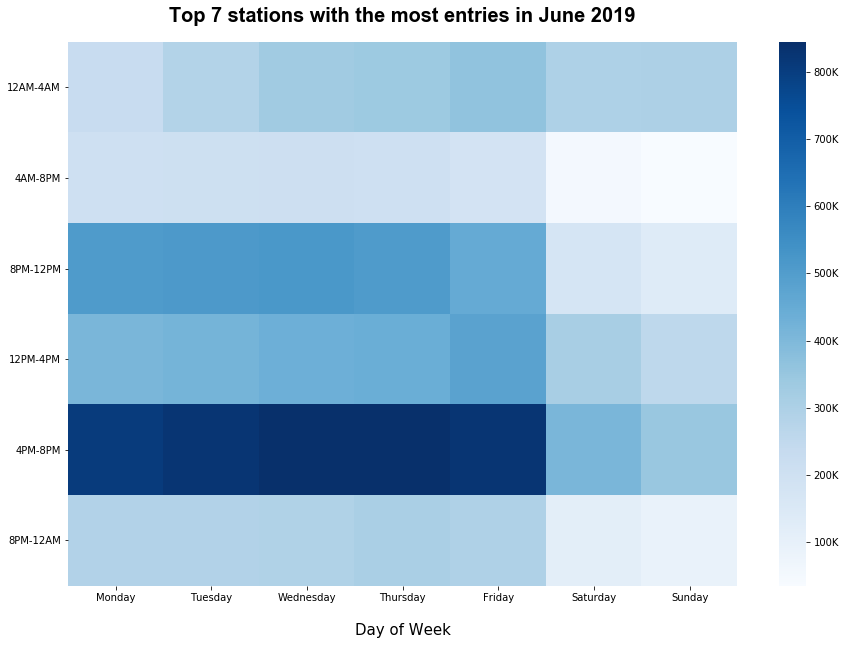

In [47]:
f, heatmap_time_entries = plt.subplots(figsize=(15, 10))
heatmap_time_entries = sns.heatmap(pv_time_entries, cmap="Blues")

heatmap_time_entries.set_title("Top 7 stations with the most entries in June 2019",
                             fontname="Arial",
                             fontsize=20,
                             fontweight='bold',
                             pad=20)

heatmap_time_entries.set_xlabel("Day of Week", labelpad = 20, fontsize=15)
heatmap_time_entries.set_ylabel("", labelpad = 20)
heatmap_time_entries.set_xticklabels(heatmap_time_entries.get_xticklabels(), rotation = 0)
heatmap_time_entries.set_yticklabels(heatmap_time_entries.get_yticklabels(), rotation = 0)


## Updating the tick name of the color scale
colorbar = heatmap_time_entries.collections[0].colorbar
colorbar_ticks = [str(int(tick))+"K" for tick in colorbar.get_ticks()/1000]
colorbar.set_ticks(colorbar.get_ticks())
colorbar.set_ticklabels(colorbar_ticks)



In [25]:
colorbar = heatmap_time_entries.collections[0].colorbar
[str(int(tick))+"K" for tick in colorbar.get_ticks()/1000]

['100K', '200K', '300K', '400K', '500K', '600K', '700K', '800K']

In [26]:
print(heatmap_time_entries.collections[0].colorbar)